<a href="https://colab.research.google.com/github/ramalias/urban-expansion/blob/main/main-urban-expansion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
#install library if needed

!pip install rasterio matplotlib numpy
!apt-get install -y gdal-bin
!gdalinfo --version

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
gdal-bin is already the newest version (3.8.4+dfsg-1~jammy0).
0 upgraded, 0 newly installed, 0 to remove and 48 not upgraded.
GDAL 3.8.4, released 2024/02/08


In [3]:
#import library

import os
import rasterio
import matplotlib.pyplot as plt
import numpy as np
import zipfile
import glob
import subprocess

In [4]:
#create main project folder
#run one time only

project_root = '/content/drive/MyDrive/project/urban-exansion'
os.makedirs(project_root, exist_ok=True)

#create folder inside project folder
os.makedirs(os.path.join(project_root, 'data'), exist_ok=True)

print('Workspace created at:', project_root)

Workspace created at: /content/drive/MyDrive/project/urban-exansion


# Unzip the Data (once)

In [5]:
dataset_base_dir = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel'

files = {
    "2019": os.path.join(dataset_base_dir, "S2B_MSIL2A_20190604T020659.zip"),
    "2024": os.path.join(dataset_base_dir, "S2A_MSIL2A_20240612T020701.zip")
}

extracted_dir = os.path.join(dataset_base_dir, 'unzipped')
os.makedirs(extracted_dir, exist_ok=True)

In [6]:
for year, path in files.items():
    year_dir = os.path.join(extracted_dir, year)
    os.makedirs(year_dir, exist_ok=True)
    with zipfile.ZipFile(path, 'r') as zip_ref:
        zip_ref.extractall(year_dir)
    print(f"Extracted {year} data to: {year_dir}")

Extracted 2019 data to: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019
Extracted 2024 data to: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2024


In [7]:
def find_bands(year_dir):
    band_files = {}
    for band in ['B02', 'B03', 'B04', 'B08']:
        pattern = f"{year_dir}/**/*{band}_10m.jp2"
        matches = glob.glob(pattern, recursive=True)
        if matches:
            band_files[band] = matches[0]
    return band_files

bands_2019 = find_bands(os.path.join(extracted_dir, "2019"))
bands_2024 = find_bands(os.path.join(extracted_dir, "2024"))

print("2019 Bands:", bands_2019)
print("2024 Bands:", bands_2024)

2019 Bands: {'B02': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190604T020659_B02_10m.jp2', 'B03': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190604T020659_B03_10m.jp2', 'B04': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190604T020659_B04_10m.jp2', 'B08': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2019/S2B_MSIL2A_20190604T020659/GRANULE/L2A_T52SDE_A011712_20190604T020701/IMG_DATA/R10m/T52SDE_20190604T020659_B08_10m.jp2'}
2024 Bands: {'B02': '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/unzipped/2024/S2A_MSIL2A_20240612T02070

# Convert JP2 to Tiff

In [8]:
# === Sentinel input folders ===
sentinel_2019 = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/S2B_MSIL2A_20190604T020659'
sentinel_2024 = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/S2A_MSIL2A_20240612T020701'

# === Output folders ===
output_base = '/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel'
output_2019 = os.path.join(output_base, 'tif2019')
output_2024 = os.path.join(output_base, 'tif2024')
os.makedirs(output_2019, exist_ok=True)
os.makedirs(output_2024, exist_ok=True)

# === Bands to extract ===
targets = ["B02", "B03", "B04", "B08", "B11"]

# === Helper function ===
def convert_sentinel_data(input_dir, output_dir, year):
    print(f"Processing {year} data...")
    for b in targets:
        # search recursively inside all subfolders (including IMG_DATA)
        pattern = os.path.join(input_dir, "**", f"*{b}*.jp2")
        src_files = sorted(glob.glob(pattern, recursive=True))

        if not src_files:
            print(f"No file found for band {b} in {year}")
            continue

        for src in src_files:
            # Keep relative path to prevent filename conflicts
            rel_path = os.path.relpath(src, input_dir).replace("/", "_")
            dst_name = rel_path.replace(".jp2", ".tif")
            dst = os.path.join(output_dir, dst_name)

            cmd = [
                "gdal_translate", "-of", "COG",
                "-co", "COMPRESS=LZW", "-co", "NUM_THREADS=ALL_CPUS",
                src, dst
            ]
            print(f"Converting [{year}] → {os.path.basename(src)}")
            subprocess.run(cmd, check=True)

    print(f"Finished converting {year}. Files saved in: {output_dir}")

# === Run conversion for both years ===
convert_sentinel_data(sentinel_2019, output_2019, 2019)
convert_sentinel_data(sentinel_2024, output_2024, 2024)

print("All conversions complete!")


Processing 2019 data...
Converting [2019] → T52SDE_20190604T020659_B02_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B02_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B02_60m.jp2
Converting [2019] → T52SDE_20190604T020659_B03_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B03_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B03_60m.jp2
Converting [2019] → T52SDE_20190604T020659_B04_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B04_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B04_60m.jp2
Converting [2019] → T52SDE_20190604T020659_B08_10m.jp2
Converting [2019] → T52SDE_20190604T020659_B11_20m.jp2
Converting [2019] → T52SDE_20190604T020659_B11_60m.jp2
Finished converting 2019. Files saved in: /content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tiff2019
Processing 2024 data...
Converting [2024] → T52SDE_20240612T020701_B02_10m.jp2
Converting [2024] → T52SDE_20240612T020701_B02_20m.jp2
Converting [2024] → T52SDE_20240612T020701_B02_60m.jp2
Conve

#Check the resolution

## 2019

In [25]:
#define sentinel folder
SENTINEL_DIR = "/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2019/tif2019_fix"
Save_dir = os.path.join(SENTINEL_DIR, "subset_grid")
os.makedirs(Save_dir, exist_ok=True)


def find_first(pattern):
    files = glob.glob(os.path.join(SENTINEL_DIR, pattern))
    return files[0] if files else None

bands = {
    "B02": find_first("*B02*.tif"),
    "B03": find_first("*B03*.tif"),
    "B04": find_first("*B04*.tif"),
    "B08": find_first("*B08*.tif"),
    "B11": find_first("*B11*.tif")
}

#Vegetative band (B08) ---> this is for reference (to check resolution, coordinate system and bound)
ref = rasterio.open(bands["B08"])
bounds = ref.bounds
print("Original resolution:", (ref.height, ref.width))
print("CRS:", ref.crs)
print("Bounds", bounds)

Original resolution: (10980, 10980)
CRS: EPSG:32652
Bounds BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)


## Preview 2019

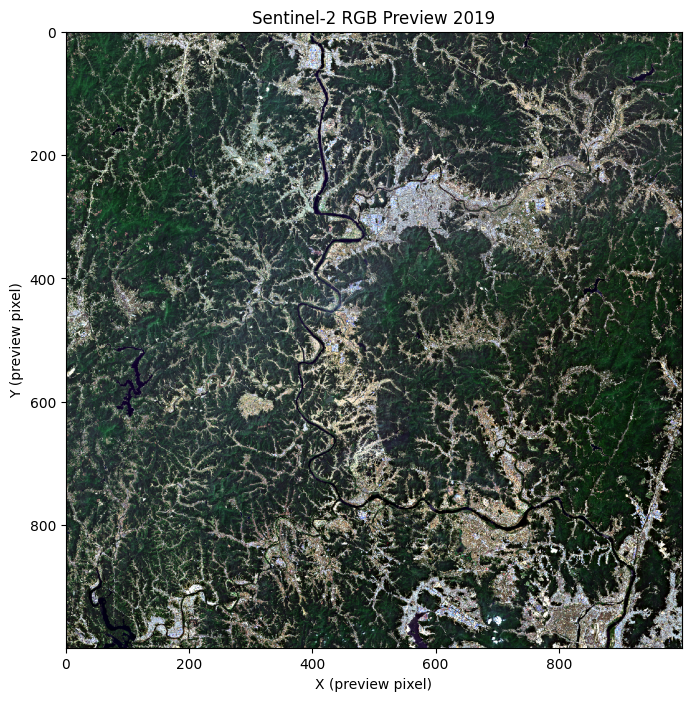

In [26]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands["B04"]) as r: R = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B03"]) as r: G = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B02"]) as r: B = r.read(1, out_shape=(scale, scale))

#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R), qstretch(G), qstretch(B)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2019")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2019/Sentinel2_preview_2019",
            dpi=300, bbox_inches='tight')
plt.show()

## 2024

In [21]:
#define sentinel folder
SENTINEL_DIR = "/content/drive/MyDrive/project/urban-exansion/data/01_Dataset_sentinel/tif2024/tif2024_fix"
Save_dir = os.path.join(SENTINEL_DIR, "subset_grid")
os.makedirs(Save_dir, exist_ok=True)


def find_first(pattern):
    files = glob.glob(os.path.join(SENTINEL_DIR, pattern))
    return files[0] if files else None

bands = {
    "B02": find_first("*B02*.tif"),
    "B03": find_first("*B03*.tif"),
    "B04": find_first("*B04*.tif"),
    "B08": find_first("*B08*.tif"),
    "B11": find_first("*B11*.tif")
}

#Vegetative band (B08) ---> this is for reference (to check resolution, coordinate system and bound)
ref = rasterio.open(bands["B08"])
bounds = ref.bounds
print("Original resolution:", (ref.height, ref.width))
print("CRS:", ref.crs)
print("Bounds", bounds)

Original resolution: (10980, 10980)
CRS: EPSG:32652
Bounds BoundingBox(left=399960.0, bottom=3890220.0, right=509760.0, top=4000020.0)


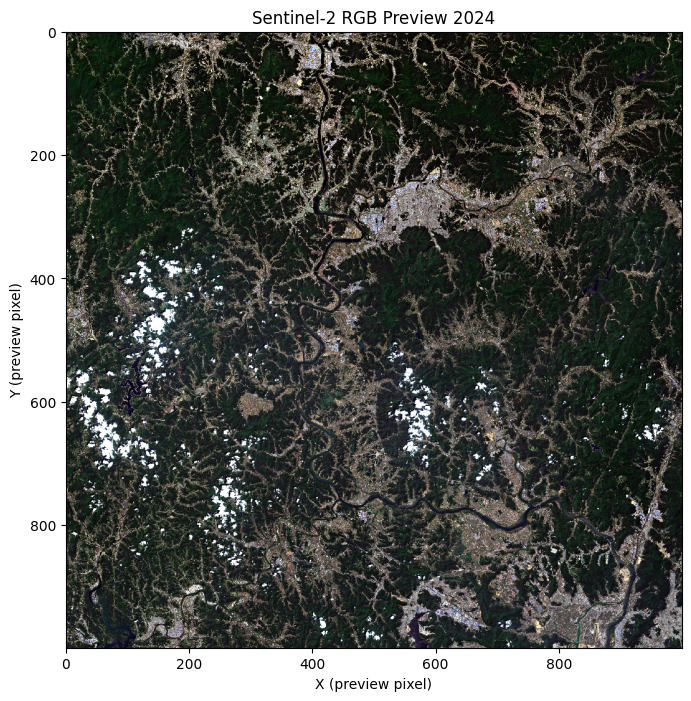

In [22]:
#Load satellite band data as arrays
scale = 1000 #means: resample to 1000x1000

with rasterio.open(bands["B04"]) as r: R = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B03"]) as r: G = r.read(1, out_shape=(scale, scale))
with rasterio.open(bands["B02"]) as r: B = r.read(1, out_shape=(scale, scale))

#Normalize and enhance contrast
def qstretch(x, low=2, high=98):
    lo, hi = np.nanpercentile(x, (low, high))
    return np.clip((x-lo)/(hi-lo+1e-6),0,1)

#Merge into RGB image
rgb = np.dstack([qstretch(R), qstretch(G), qstretch(B)])

#Display the preview
fig, ax = plt.subplots(figsize=(8,8))
ax.imshow(rgb, origin="upper")

plt.title("Sentinel-2 RGB Preview 2024")
plt.xlabel("X (preview pixel)")
plt.ylabel("Y (preview pixel)")

# Save the preview
plt.savefig("/content/drive/MyDrive/project/urban-exansion/output/2024/Sentinel2_preview_2024",
            dpi=300, bbox_inches='tight')
plt.show()